<a href="https://colab.research.google.com/github/CalipsoAdara/SMN/blob/verif_S2/CHIRPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESCARGA DE CHIRPS
Codigo para descargar data diaria del CHIRPS, en formato NETCDF

---

[CHIRPS DATA GLOBAL](https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/)

## Instalacion e importar librerias necesarias

In [1]:
# instalar
!pip install xarray
!pip install cartopy
!pip install shapely==1.8.5
!pip install datetime
!pip install metpy
!pip install matplotlib==3.1.3
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.9 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp38-cp38-linux_x86_64.whl size=11127992 sha256=313aebf556ea71de5a0864b779332c08f9fcaa7e83015bfc448d0ede522ba3ea
  Stored in directory: /root/.cache/pip/wheels/7c/ff/6f/09e4aa53f4e67d6498ef1d33dd4ea9c8c165817b9ddcc31d28
Successfully built cartopy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.0
    Uninstalling matplotlib-3.7.0:
      Successfully uninstalled matplotlib-3.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
metpy 1.4.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=06110dfcedcd8e3f7d825e7419c7560418dbd8581cb3519864a7b49ecf7b4752
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d89

In [2]:
# importar
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import osgeo.ogr
import wget 


In [3]:
# Montar drive  (esto se elimina al realizar el codigo en el server)
from google.colab import drive
drive.mount('/content/drive')
os.chdir('./drive/MyDrive/Verifsem2')

Mounted at /content/drive


## Descarga de NETCDF por mes
Todos los años, todos los meses. Desde 1981 a 2022

In [4]:
# Descarga de netcdf por mes
root = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/by_month/"

# Periodo
years = range(1981,2022+1)  # el +1 para que incluya el ultimo valor
meses = range(1,12+1)


# Nombre de los archivos
filelist = ["chirps-v2.0."+str(y) +"."+str(m)+".days_p05.nc" for y in years for m in meses]

In [ ]:
# Restringir a sur de Sudamerica
for f in filelist:

  # Descargo
  URL = root + f
  response = wget.download(URL,f)

  # Leo con xarray
  ds = xr.open_dataarray(f)

  # Selecciono cuadrado 
  ds_sa = ds.sel(latitude = slice(-49.75,-10.75), longitude = slice(-90.25,-29.75))  
  #-50 a -10 y -90 a -30
  # hay que tener en cuenta que para obtener los puntos en la longitud -30 hace la media  
  # con valores que no tiene. NO es tan grave ya que ahi hay oceano y no hay info

  # Guardo
  ds_sa.to_netcdf(f[0:27] + "_SA.nc")

In [7]:
# Nombre de los archivos
filelist = ["chirps-v2.0."+str(y) +"."+str(m)+".days_SA.nc" for y in years for m in meses]
filelist[1][0:26]

'chirps-v2.0.1981.2.days_SA'

####**Tema: Downscaling ⚡**

Para poder comparar GFS y CHIRPS es necesario reducir la resolucion del CHIRPS de 0.05°x0.05° a la del GFS (0.5°x0.5°). Antes de realizar el downscaling, guardamos la data del CHIRPS correspondiente al cuadrado de SUDAMERICA.

*0.05° ---> 0.5°*

*osea, necesito **promediar** 10 pixeles de 0.05° para obtener 0.5°*

Como vamos a reducir la resolucion, con la funcion "coarse" de XARRAY, es importante notar dos cosas. La *primera* que es necesario tener dimensiones pares. La *segunda*, que vamos a perder informacion en los bordes. Por ejemplo, como el CHIRPS solo llega hasta 50°S al downscalear vamos a perder medio grado de informacion.

La region de Sudamerica deseada es:

-latitud: de 50°S a 10°S

-longitud: de 90°O a 30°O  (o 270° a 330°)

Considerando eso, y que quiero que los valores al downscalear queden de la forma 90, 89.5, 89, 88.5 ,etc en vez de 90.75, 90.25, 89.75, 89.25, etc, el recorte del archivo chirps se hace: 

-latitud: de 49.75°S a 10.75°S

-longitud: de 90.25°O a 29.75°O 

## Downscaling

In [ ]:
# Nombre de los archivos
filelist = ["chirps-v2.0."+str(y) +"."+str(m)+".days_SA.nc" for y in years for m in meses]

for f in filelist:
  # Leo con xarray
  ds = xr.open_dataarray(f)

  # DOWNSCALING 
  ds_down = ds.coarsen(latitude=10, longitude=10).mean()

  # Guardo
  ds_sa.to_netcdf(f[0:26] + "_down.nc")

Float64Index([-49.974998474121094,  -49.92499923706055,             -49.875,
               -49.82499694824219,  -49.77499771118164, -49.724998474121094,
               -49.67499923706055,             -49.625,  -49.57499694824219,
               -49.52499771118164,
              ...
               49.524993896484375,   49.57499694824219,   49.62499237060547,
                49.67499542236328,  49.724998474121094,  49.774993896484375,
                49.82499694824219,   49.87499237060547,   49.92499542236328,
               49.974998474121094],
             dtype='float64', name='latitude', length=2000)


In [ ]:
ds_sa.shape

(31, 780, 1210)

In [ ]:
# DOWNSCALING 
ds_sa_down = ds_sa.coarsen(latitude=10, longitude=10).mean()
ds_sa_down.shape

(31, 78, 121)

In [ ]:
ds_sa_down

<xarray.DataArray 'precip' (time: 31, latitude: 78, longitude: 121)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -49.5 -49.0 -48.5 -48.0 ... -12.0 -11.5 -11.0
  * longitude  (longitude) float32 -90.0 -89.5 -89.0 -88.5 ... -31.0 -30.5 -30.0
  * time       (time) datetime64[ns] 2022-12-01 2022-12-02 ... 2022-12-31
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

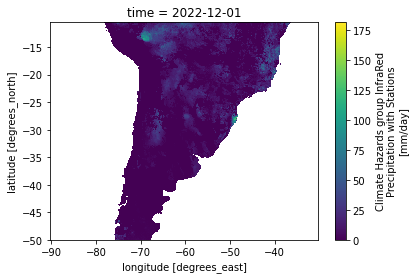

In [ ]:
ds_sa.isel(time=0).plot()

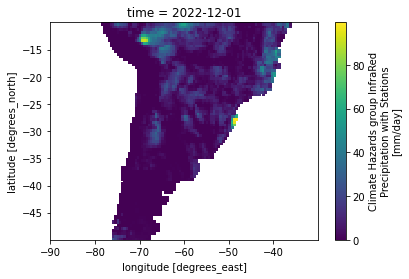

In [ ]:
ds_sa_down.isel(time=0).plot()

In [ ]:
  # Guardo
ds_sa_down.to_netcdf("interpo_SA.nc")

In [ ]:
print(ds_sa_down.indexes['latitude'])
print(ds_sa_down.indexes['longitude'])

Float64Index([-49.499996185302734, -48.999996185302734, -48.499996185302734,
              -47.999996185302734, -47.499996185302734, -46.999996185302734,
              -46.499996185302734, -45.999996185302734, -45.499996185302734,
              -44.999996185302734, -44.499996185302734, -43.999996185302734,
              -43.499996185302734, -42.999996185302734, -42.499996185302734,
              -41.999996185302734, -41.499996185302734, -40.999996185302734,
              -40.499996185302734, -39.999996185302734, -39.499996185302734,
              -38.999996185302734, -38.499996185302734, -37.999996185302734,
              -37.499996185302734, -36.999996185302734, -36.499996185302734,
              -35.999996185302734,               -35.5,               -35.0,
                            -34.5, -33.999996185302734, -33.499996185302734,
              -32.999996185302734, -32.499996185302734,               -32.0,
                            -31.5,               -31.0,               -30.5,